In [1]:
! pip install requests
! pip install tensorflow==2.0.0-beta1 --user --ignore-installed
! pip install keras

  Using cached https://files.pythonhosted.org/packages/24/2c/373d2847538fdd65742ad19df23946e0d0a8f1df7f5f0c6bce6e9b293088/tensorflow-2.0.0b1-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bb/10/44230dd6bf3563b8f227dbf344c908d412ad2ff48066476672f3a72e174e/wheel-0.33.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a4/96/571b875cd81dda9d5dfa1422a4f9d749e67c0a8d4f4f0b33a4e5f5f35e27/tb_nightly-1.14.0a20190603-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d1/4f/950dfae467b384fc96bc6469de25d832534f6b4441033c39f914efd13418/astor-0.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/32/dd/99c47dd007dcf10d63fd895611b063732646f23059c618a373e85019eb0e/tf_estimator_nightly-1.14.0.dev2019060501-py2.py3-none-any.whl
  Using 

In [2]:
import requests
from bs4 import BeautifulSoup # parsing HTML
from keras.utils import get_file

Using TensorFlow backend.
C:\Users\efan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\efan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\efan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\efan\AppData\Roaming

Access a dump (snapshot) of the entire Wikipedia

In [3]:
base_url = 'https://dumps.wikimedia.org/enwiki/'
index = requests.get(base_url).text

Use BeautifulSoup to create a parse tree that can be used to extract data from HTML, and find the links on the page

In [4]:
soup_index = BeautifulSoup(index, 'html.parser')
dumps = [a['href'] for a in soup_index.find_all('a') if 
         a.has_attr('href')]
dumps

['../',
 '20190420/',
 '20190501/',
 '20190520/',
 '20190601/',
 '20190620/',
 '20190701/',
 '20190720/',
 'latest/']

Choose a complete dump and find all available files in the dump

In [5]:
dump_url = base_url + '20190701/'
# Retrieve the html
dump_html = requests.get(dump_url).text
# Convert to a soup
soup_dump = BeautifulSoup(dump_html, 'html.parser')
# Find list elements with the class file
soup_dump.find_all('li', {'class': 'file'})[:3]

[<li class="file"><a href="/enwiki/20190701/enwiki-20190701-pages-articles-multistream.xml.bz2">enwiki-20190701-pages-articles-multistream.xml.bz2</a> 16.0 GB</li>,
 <li class="file"><a href="/enwiki/20190701/enwiki-20190701-pages-articles-multistream-index.txt.bz2">enwiki-20190701-pages-articles-multistream-index.txt.bz2</a> 203.7 MB</li>,
 <li class="file"><a href="/enwiki/20190701/enwiki-20190701-pages-articles-multistream1.xml-p10p30302.bz2">enwiki-20190701-pages-articles-multistream1.xml-p10p30302.bz2</a> 171.4 MB</li>]

Limit to only the files containing 'pages-articles' to get only the recent versions of the articles

In [6]:
files = []

# Search through all files
for file in soup_dump.find_all('li', {'class': 'file'}):
    text = file.text
    # Select the relevant files
    if 'pages-articles-multistream' in text:
        files.append((text.split()[0], text.split()[1:]))
        
files[:5]

[('enwiki-20190701-pages-articles-multistream.xml.bz2', ['16.0', 'GB']),
 ('enwiki-20190701-pages-articles-multistream-index.txt.bz2', ['203.7', 'MB']),
 ('enwiki-20190701-pages-articles-multistream1.xml-p10p30302.bz2',
  ['171.4', 'MB']),
 ('enwiki-20190701-pages-articles-multistream-index1.txt-p10p30302.bz2',
  ['163', 'KB']),
 ('enwiki-20190701-pages-articles-multistream2.xml-p30304p88444.bz2',
  ['203.8', 'MB'])]

Further filter for partitioned files with 'xml-p'

In [7]:
files_to_download = [file[0] for file in files if '.xml-p' in file[0]]
files_to_download[-5:]

['enwiki-20190701-pages-articles-multistream27.xml-p54663464p56163464.bz2',
 'enwiki-20190701-pages-articles-multistream27.xml-p56163464p57663464.bz2',
 'enwiki-20190701-pages-articles-multistream27.xml-p57663464p59163464.bz2',
 'enwiki-20190701-pages-articles-multistream27.xml-p59163464p60663464.bz2',
 'enwiki-20190701-pages-articles-multistream27.xml-p60663464p61197528.bz2']

Check if file already exists and if not download file

In [8]:
import os # File system management
import sys
os.getcwd()

'C:\\Users\\efan'

In [9]:
keras_home = 'C:\\Users\\efan\\.keras\\datasets\\'
data_paths = []
file_info = []

# Iterate through each file
for file in files_to_download:
    path = keras_home + file
    
    # Check to see if the path exists (if the file is already downloaded)
    if not os.path.exists(keras_home + file):
        print('Downloading')
        # If not, download the file
        data_paths.append(get_file(file, dump_url + file))
        # Find the file size in MB
        file_size = os.stat(path).st_size / 1e6
        
        # Find the number of articles
        file_articles = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file, file_size, file_articles))
        
    # If the file is already downloaded find some information
    else:
        data_paths.append(path)
        # Find the file size in MB
        file_size = os.stat(path).st_size / 1e6
        
        # Find the number of articles
        file_number = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file.split('-')[-1], file_size, file_number))

Sort by file size to see the largest files

In [10]:
sorted(file_info, key = lambda x: x[1], reverse = True)[:5]

[('p6197599p7697599.bz2', 429.065475, 1500000),
 ('p3926864p5040435.bz2', 426.410203, 1113571),
 ('p5040438p6197593.bz2', 422.317373, 1157155),
 ('p3046517p3926861.bz2', 410.675319, 880344),
 ('p7744803p9244803.bz2', 405.355571, 1500000)]

Find out how many partitions there are in total

In [11]:
print(f'There are {len(file_info)} partitions.')

There are 57 partitions.


Put this info into a dataframe to plot the file sizes

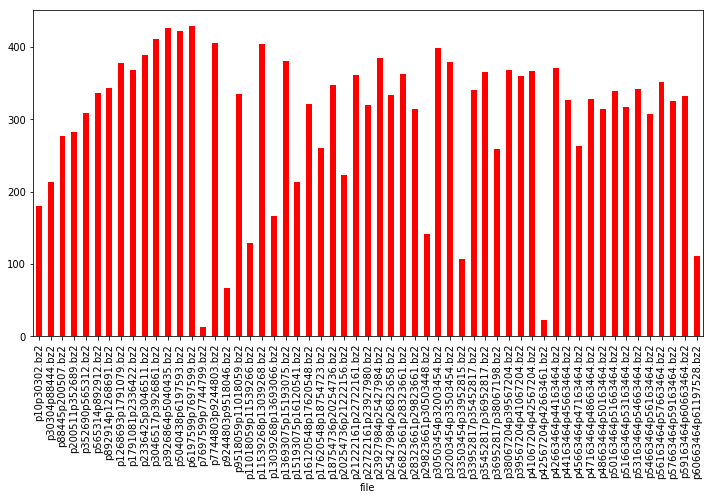

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
file_df = pd.DataFrame(file_info, columns = ['file', 'size (MB)', 'articles']).set_index('file')
file_df['size (MB)'].plot.bar(color = 'red', figsize = (12, 6));

Find out the total file size

In [13]:
print(f"The total size of files on disk is {file_df['size (MB)'].sum() / 1e3} GB")

The total size of files on disk is 17.228228624 GB


Import libraries to process bz2 compressed files line by line

In [14]:
import bz2
import subprocess

Parsing Step 1: Extract the titles and article text from the XML using SAX

In [15]:
! pip install mwparserfromhell

In [214]:
def process_article(title, text, timestamp, template = 'Infobox person'):
    """Process a wikipedia article looking for template"""
    
    # Create a parsing object
    wikicode = mwparserfromhell.parse(text)
    
    # Search through templates for the template
    matches = wikicode.filter_templates(matches = template)
    
    # Filter out errant matches
    matches = [x for x in matches if x.name.strip_code().strip().lower() == template.lower()]
    
    if len(matches) >= 1:
        # template_name = matches[0].name.strip_code().strip()

        # Extract information from infobox
        properties = {param.name.strip_code().strip(): param.value.strip_code().strip() 
                      for param in matches[0].params
                      if param.value.strip_code().strip()}

        # Extract internal wikilinks
        wikilinks = [x.title.strip_code().strip() for x in wikicode.filter_wikilinks()]

        return (title, properties, wikilinks, timestamp)

In [215]:
import xml.sax
import re
class WikiXmlHandler(xml.sax.handler.ContentHandler):
    """Parse through XML data using SAX"""
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        self._people = []
        self._article_count = 0
        self._non_matches = []

    def characters(self, content):
        """Characters between opening and closing tags"""
        if self._current_tag:
            self._buffer.append(content)

    def startElement(self, name, attrs):
        """Opening tag of element"""
        if name in ('title', 'text', 'timestamp'):
            self._current_tag = name
            self._buffer = []

    def endElement(self, name):
        """Closing tag of element"""
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)

        if name == 'page' and (re.search('21st\-century\s+(?:(?!\s+actors")(?:.|\n))*\s+actors', str(self._buffer))
                               or
                               re.search('21st\-century\s+(?:(?!\s+actors")(?:.|\n))*\s+actresses', str(self._buffer))):
            self._article_count += 1
            # Search through the page to see if the page is a book
            people = process_article(**self._values, template = 'Infobox person')
            # Append to the list of books
            if people:
                self._people.append(people)

In [216]:
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    parser.feed(line)
    
    # Stop when 3 articles have been found
    if len(handler._people) > 10:
        break
        
print(f'Searched through {handler._article_count} articles to find 10 people.')

Searched through 13 articles to find 10 people.


In [217]:
handler._people[0]

('Barbora Bobuľová',
 {'name': 'Barbora Bobuľová',
  'image': 'Barbora Bobulova 2011-01.jpg',
  'caption': 'Bobulová in 2011',
  'birth_place': 'Martin, Czechoslovakia (present-day Slovakia)',
  'death_date': '< !--  Death date then birth -- >',
  'occupation': 'Actress'},
 ['Martin, Slovakia',
  'Slovakia',
  'Slovakia',
  'Martin, Slovakia',
  'Bratislava',
  'The Prince of Homburg (film)',
  '1997 Cannes Film Festival',
  'Cuore Sacro',
  'David di Donatello',
  "Ciak d'oro",
  'Flaiano Film Festival',
  "Nastro d'Argento",
  'In Love and War (2001 film)',
  'Eric Newby',
  'Shirley MacLaine',
  'Coco Chanel (film)',
  'Slovak language',
  'Czech language',
  'Nesmrtelná teta',
  'The Prince of Homburg (film)',
  'Ecco fatto',
  'Paul, the apostle',
  'Mirka (film)',
  'Padre Pio: Between Heaven and Earth',
  'In Love and War (2001 film)',
  'The Crusaders (2001 film)',
  'La Cittadella (2003)',
  'miniseries',
  'The Vanity Serum',
  'The Spectator (film)',
  'Ovunque sei',
  'Cuor